# Prep 

In [1]:
# imports
import numpy as np
import os
from os import path

from scipy.signal import convolve


import matplotlib.pyplot as plt
import scipy.sparse.linalg as ssl
from scipy.signal import filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *
import sys
sys.path.insert(0,'../scripts/')
from calibrate import calibrate
from time import time
from pylops.signalprocessing import Fredholm1
import pylops
from scipy.sparse.linalg import LinearOperator
from copy import deepcopy as dc

In [2]:
#load full data for test
datapath = '../data'
inputfile = os.path.join(datapath, 'input_full_v2.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1750.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

method = 'src_ana'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 1100, 0.003
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

# Data
p = inputdata['p']
vz = inputdata['vz']

p = np.apply_along_axis(convolve, 1, p, wav, mode='full')
p = p[:, wav_c:][:, :nt]
vz = np.apply_along_axis(convolve, 1, vz, wav, mode='full')
vz = vz[:, wav_c:][:, :nt]

# Normalize
vz /= p.max()
p /= p.max()

R1 = inputdata['vzmdd1']

In [3]:
# load data
datapath = '../data'
inputfile = os.path.join(datapath, 'input_full.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1750.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

method = 'src_ana'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]
# load data
datapath = '../data'
inputfile = os.path.join(datapath, 'input_full.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1750.0 # velocity at separation level
rho_sep = 1000.0 # density at separation level

method = 'src_ana'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 1100, 0.003
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

# Data
p = inputdata['p']
vz = inputdata['vz']

p = np.apply_along_axis(convolve, 1, p, wav, mode='full')
p = p[:, wav_c:][:, :nt]
vz = np.apply_along_axis(convolve, 1, vz, wav, mode='full')
vz = vz[:, wav_c:][:, :nt]

# Normalize
vz /= p.max()
p /= p.max()

In [4]:
# gen pup pdown
if path.exists(datapath + f'/updown_{method}.npz'):
    tmp_dict = np.load(datapath + f'/updown_{method}.npz')
    pup = tmp_dict['pup']
    pdown = tmp_dict['pdown']
else:
    #fft
    nfft=2**11
    FFTop = FFT2D(dims=[nr, nt], 
                  nffts=[nfft, nfft], sampling=[dr, dt])
    dottest(FFTop, nfft*nfft, nt*nr, complexflag=2)

    critical = 0.9
    ntaper = 9 # 7
    cutoff = 1e7 # 1e8

    #obliquity factor
    [Kx, F] = np.meshgrid(FFTop.f1, FFTop.f2, indexing='ij')
    k=F/vel_sep
    Kz=np.sqrt((k**2-Kx**2).astype(complex))
    Kz[np.isnan(Kz)] = 0

    # obliquities
    OBL=rho_sep*(np.abs(F)/Kz)
    OBL[Kz==0]=0
    OBL[OBL>cutoff]=0

    OBL1 = Kz /(rho_sep*np.abs(F))
    OBL1[F==0] = 0
    OBL1[OBL1<1./cutoff]=0

    # cut off and taper
    mask = np.abs(Kx)<critical*np.abs(F)/vel_sep
    mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=0)
    mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=1)

    OBL = OBL*mask
    OBL1 = OBL1*mask

    # analytical separation
    Maskop = Diagonal(mask.ravel(), dtype='complex128')
    OBLop = Diagonal(OBL.ravel(), dtype='complex128')

    Sop = 0.5*(BlockDiag([FFTop.H, FFTop.H])*\
        Block([[Maskop, OBLop],
               [Maskop, -OBLop]])*\
               BlockDiag([FFTop, FFTop]))
    
    # calibration params
    twin = [0.01, 0.07]
    nfilt = 15

    pup = np.zeros((ns, nt, nr))
    pdown = np.zeros((ns, nt, nr))

    if method == 'sum':
        for isrc in range(0,ns):
            if isrc % 10 == 0:
                print(f'Working with source {isrc}/{ns}')
            vzcalib = calibrate(p[isrc].T, vz[isrc].T, s, r, isrc, dt, nt, vel_dir, vel_sep, 
                                rho_sep, twin=twin, nfilt=nfilt, plotflag=False)

            pdown[isrc] = (p[isrc] + vzcalib.T*(rho_sep*vel_sep) ) / 2.
            pup[isrc] = (p[isrc] - vzcalib.T*(rho_sep*vel_sep) ) / 2.

    elif method == 'src_ana':
        for isrc in range(0,ns):
            if isrc % 10 == 0:
                print(f'Working with source {isrc}/{ns}')
            vzcalib = calibrate(p[isrc].T, vz[isrc].T, s, r, isrc, dt, nt, vel_dir, vel_sep, 
                                rho_sep, twin=twin, nfilt=nfilt, plotflag=False)

            d = np.concatenate((p[isrc].T.ravel(), vzcalib.ravel()))
            dud = np.real(Sop*d)

            d = d.reshape(2*nr, nt)
            dud = dud.reshape(2*nr, nt)
            pdown[isrc], pup[isrc] = dud[:nr].T, dud[nr:].T

    elif method == 'rec_ana':
        for irec in range(nr):
            if irec % 10 == 0:
                print(f'Working with receiver {irec}/{nr}')

            vzcalib = calibrate(p[..., irec], vz[..., irec], r, s, irec, dt, nt, vel_dir, vel_sep, rho_sep,
                                twin=twin, nfilt=nfilt, plotflag=False)

            d = np.concatenate((p[...,irec].ravel(), vzcalib.ravel()))
            dud = np.real(Sop*d)

            d = d.reshape(2*ns, nt)
            dud = dud.reshape(2*ns, nt)
            pdown[...,irec], pup[...,irec] = dud[:ns], dud[ns:]

    elif method == 'src_inv':
        for isrc in range(ns):
            if isrc % 10 == 0:
                print(f'Working with source {isrc}/{ns}')
            vzcalib = calibrate(p[isrc].T, vz[isrc].T, s, r, isrc, dt, nt, vel_dir, vel_sep, 
                                rho_sep, twin=twin, nfilt=nfilt, plotflag=False)

            # separation by inversion
            OBLop = Diagonal(OBL1.flatten(), dtype='complex128')
            Maskop = Diagonal(mask.flatten(), dtype='complex128')

            S1op_scaled = (BlockDiag([FFTop.H, (p[isrc].max()/vzcalib.max())*FFTop.H])*\
                    Block([[Maskop, Maskop],
                           [OBLop, -OBLop]]) * BlockDiag([FFTop, FFTop]))

            d = np.concatenate((FFTop.H * Maskop * FFTop * p[isrc].T.flatten(), 
                                (p[isrc].max()/vzcalib.max()) * FFTop.H * Maskop * FFTop * vzcalib.flatten()))

            dud_inv, istop, itn, r1norm, r2norm = \
                lsqr(S1op_scaled, d.flatten(), damp=1e-10, 
                     iter_lim=10, show=0)[0:5]
            dud_inv = np.real(dud_inv)
            dud_inv = dud_inv.reshape(2*nr, nt)

            pdown_inv, pup_inv= dud_inv[:nr], dud_inv[nr:]

            # clean up data outside of spectral cone
            pdown_inv = np.real(np.reshape(FFTop.H * Maskop * FFTop * pdown_inv.ravel(), (nr, nt)))
            pup_inv = np.real(np.reshape(FFTop.H * Maskop * FFTop * pup_inv.ravel(), (nr, nt)))

            # clean up data outside of spectral cone
            pdown[isrc] = pdown_inv.T
            pup[isrc] = pup_inv.T
    np.savez(os.path.join(datapath, 'updown_%s' % method), pup=pup, pdown=pdown)

In [5]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0))).astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0))).astype('float32')
ntpad = pup.shape[1]

# nfmax=200

# fig, axs = plt.subplots(1, 2, figsize=(9,6))
# axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
#               extent = (r[0, 0], r[0,-1], t[-1], t[0]))
# axs[0].set_title(r'$pup$')
# axs[0].axis('tight')
# axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
#               extent = (r[0,0], r[0,-1], t[-1], t[0]))
# axs[1].set_title(r'$pdown$')
# axs[1].axis('tight');

In [6]:
#set up MCD
G = pdown.transpose(0, 2, 1).copy()
d = pup.transpose(0, 2, 1).copy()

twosided = 0
saveGt = 1
fftengine="numpy"
iter_lim=20

ncp = get_array_module(d)

ns, nr, nt = G.shape

nfmax=200

if len(d.shape) == 2:
    nv = 1
else:
    nv = d.shape[1]
# nv = 1
nt2 = nt
nfmax_allowed = nt 
# Fix nfmax to be at maximum equal to half of the size of fft samples
if nfmax is None or nfmax > nfmax_allowed:
    nfmax = nfmax_allowed
    logging.warning("nfmax set equal to ceil[(nt+1)/2=%d]" % nfmax)
    
# Bring kernel to frequency domain
Gfft = np.fft.rfft(G, nt2, axis=-1)
Gfft = Gfft[..., :nfmax]

# Bring frequency/time to first dimension
Gfft = np.moveaxis(Gfft, -1, 0)
d = np.moveaxis(d, -1, 0)

In [7]:
#ops
def ops(nt,nv,ns,nr):
    from pylops import Identity
    from pylops.signalprocessing import FFT

    nfft = int(np.ceil((nt + 1) / 2))
    Iop = Identity(
        N=nfmax * nr * nv, M=nfft * nr * nv, inplace=True, dtype='float64')
    I1op = Identity(
        N=nfmax * ns * nv, M=nfft * ns * nv, inplace=True, dtype='float64')
    I1opH = I1op.H

    Fop = FFT(dims=(nt, nr, nv), dir=0, real=True, ifftshift_before=twosided, engine = 'numpy')
    F1op = FFT(
        dims=(nt, ns, nv),
        dir=0,
        real=True,
        ifftshift_before=False,
        engine = 'numpy')
    F1opH = F1op.H
    Iop_com = Identity(N=nfmax * nr * nv, M=nfft * nr * nv, inplace=True, dtype=complex)
    I1op_com = Identity(N=nfmax * ns * nv, M=nfft * ns * nv, inplace=True, dtype=complex)
    I1opH_com = I1op_com.H
    return Iop_com, Fop, I1opH_com, F1opH
# Fredholm
import numpy as np

from pylops import LinearOperator
from pylops.utils.backend import get_array_module


class Fredholm1(LinearOperator):
    def __init__(self, G, nz=1, saveGt=True, usematmul=True, dtype="float64"):
        self.nz = nz
        self.nsl, self.nx, self.ny = G.shape
        self.G = G
        if saveGt:
            self.GT = G.transpose((0, 2, 1)).conj()
        self.usematmul = usematmul
        self.shape = (self.nsl * self.nx * self.nz, self.nsl * self.ny * self.nz)
        self.dtype = np.dtype(dtype)
        self.explicit = False

    def _matvec(self, x):
        ncp = get_array_module(x)
#         x = ncp.squeeze(x.reshape(self.nsl, self.ny, self.nz))
        x = x.reshape(self.nsl, self.ny, self.nz)
        if self.usematmul:
            if self.nz == 1:
                x = x[..., ncp.newaxis]
            y = ncp.matmul(self.G, x)
        else:
#             y = ncp.squeeze(ncp.zeros((self.nsl, self.nx, self.nz), dtype=self.dtype))
            y = ncp.zeros((self.nsl, self.nx, self.nz), dtype=self.dtype)
            for isl in range(self.nsl):
                y[isl] = ncp.dot(self.G[isl], x[isl])
        return y.ravel()

    def _rmatvec(self, x):
        ncp = get_array_module(x)
#         x = ncp.squeeze(x.reshape(self.nsl, self.nx, self.nz))
        x = x.reshape(self.nsl, self.nx, self.nz)
#         print (f'rhs.shape: {x.shape}')
        if self.usematmul:
            if self.nz == 1:
                x = x[..., ncp.newaxis]
            if hasattr(self, "GT"):
                y = ncp.matmul(self.GT, x)
            else:
                # y = ncp.matmul(self.G.transpose((0, 2, 1)).conj(), x)
                y = (
                    ncp.matmul(x.transpose(0, 2, 1).conj(), self.G)
                    .transpose(0, 2, 1)
                    .conj()
                )
        else:
#             y = ncp.squeeze(ncp.zeros((self.nsl, self.ny, self.nz), dtype=self.dtype))
            y = ncp.zeros((self.nsl, self.ny, self.nz), dtype=self.dtype)
#             print (f'ans.shape: {y.shape}')
            if hasattr(self, "GT"):
                if 0: #self.nsl == 1:
                    y = ncp.dot(self.GT[0], x)
                else:
                    for isl in range(self.nsl):
                        y[isl] = ncp.dot(self.GT[isl], x[isl])
            else:
                for isl in range(self.nsl):
                    # y[isl] = ncp.dot(self.G[isl].conj().T, x[isl])
                    y[isl] = ncp.dot(x[isl].T.conj(), self.G[isl]).T.conj()
        return y.ravel()
Frop = Fredholm1(dr * dt * np.sqrt(nt) * Gfft, nv, saveGt=saveGt, dtype=complex, usematmul=False)

In [8]:
Iopf, Fopf, IopHf, F1opHf = ops(nt,nv,ns,nr)
Iop, Fop, IopH, F1opH = ops(nt,1,ns,nr)

rhs_fr = Iopf.matvec(Fopf.matvec(d.ravel()))
rhs_fr = rhs_fr.reshape(nfmax,nr,nv)

# H2 approx in USV form

In [9]:
class Geometry(object):
    def __init__(self, tree,  verbose=False):
        self.tree = tree
        self.data = tree.data
        self.shape = (len(tree.data), len(tree.data))
#         self.dtype = tmp.dtype
        self._build(verbose)
    def _build(self, verbose=False):
        row_check = [[0]]
        self.far = []
        self.close = []
        self.notransition = []
        self.tree.aux =[self.data.compute_aux(self.tree.index[0])]
        cur_level = 0
        col_tree = self.tree
        while (self.tree.level[cur_level] < self.tree.level[cur_level+1]):
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                self.far.append([])
                self.close.append([])
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                for j in row_check[i]:
                    if self.tree.is_far(i, col_tree, j):
                        self.far[i].append(j)

                    else:
                        self.close[i].append(j)
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                if i == 0:
                    self.notransition.append(not self.far[i])
                else:
                    self.notransition.append(not(self.far[i] or
                        not self.notransition[self.tree.parent[i]]))
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                if (self.close[i] and not self.tree.child[i] and
                        self.tree.index[i].size >
                        self.tree.block_size):
                    nonzero_close = False
                    for j in self.close[i]:
                        if (col_tree.index[j].size >
                                col_tree.block_size):
                            nonzero_close = True
                            break
                    if nonzero_close:
                        self.tree.divide(i)
            for i in range(self.tree.level[cur_level],self.tree.level[cur_level+1]):
                whom_to_check = []
                for j in self.close[i]:
                    whom_to_check.extend(col_tree.child[j])
                for j in self.tree.child[i]:
                    row_check.append(whom_to_check)
            self.tree.level.append(len(self.tree))
            cur_level += 1
        self.num_levels = len(self.tree.level)-1
        self.tree.num_levels = self.num_levels
class SmartIndex(object):
    def __init__(self, size):
        self.index = np.arange(size, dtype=np.uint64)
        self.node = [(0, size)]

    def __getitem__(self, key):
        """Get indices for cluster `key`."""
        return self.index[slice(*self.node[key])]

    def __setitem__(self, key, value):
        """
        Set indices for cluster `key`.

        Changes only main index array.
        """
        self.index[slice(*self.node[key])] = value

    def add_node(self, parent, node):
        """Add node, that corresponds to `index[node[0]:node[1]]`."""
        start = self.node[parent][0]+node[0]
        stop = self.node[parent][0]+node[1]
        self.node.append((start, stop))

    def __len__(self):
        return len(self.node)
class Data(object):
    def __init__(self, ndim, count, vertex, close_r='1box'):
        self.ndim = ndim
        self.count = count
        self.vertex = vertex
        self.close_r = close_r
    def check_far(self, self_aux, other_aux):
        return Data.fast_check_far_ndim(self_aux, other_aux, self.ndim, self.close_r)
    def fast_check_far_ndim(self_aux, other_aux, ndim, close_r):
        if close_r == '1box':
            if ndim == 2:
                corners_self = [np.array([self_aux[0,0], self_aux[0,1]]),
                                np.array([self_aux[1,0], self_aux[0,1]]),
                                np.array([self_aux[0,0], self_aux[1,1]]),
                                np.array([self_aux[1,0], self_aux[1,1]])]
                corners_other = [np.array([other_aux[0,0], other_aux[0,1]]),
                                 np.array([other_aux[1,0], other_aux[0,1]]),
                                 np.array([other_aux[0,0], other_aux[1,1]]),
                                 np.array([other_aux[1,0], other_aux[1,1]])]
                for i in corners_self:
                    for j in corners_other:
                        if np.array_equal(i,j):
                            return False

                return True
            elif ndim == 3:
                corners_self = [np.array([self_aux[0,0], self_aux[0,1], self_aux[0,2]]),
                                np.array([self_aux[0,0], self_aux[0,1], self_aux[1,2]]),
                                np.array([self_aux[0,0], self_aux[1,1], self_aux[0,2]]),
                                np.array([self_aux[0,0], self_aux[1,1], self_aux[1,2]]),
                                np.array([self_aux[1,0], self_aux[0,1], self_aux[0,2]]),
                                np.array([self_aux[1,0], self_aux[0,1], self_aux[1,2]]),
                                np.array([self_aux[1,0], self_aux[1,1], self_aux[0,2]]),
                                np.array([self_aux[1,0], self_aux[1,1], self_aux[1,2]])]
                corners_other = [np.array([other_aux[0,0], other_aux[0,1], other_aux[0,2]]),
                                 np.array([other_aux[0,0], other_aux[0,1], other_aux[1,2]]),
                                 np.array([other_aux[0,0], other_aux[1,1], other_aux[0,2]]),
                                 np.array([other_aux[0,0], other_aux[1,1], other_aux[1,2]]),
                                 np.array([other_aux[1,0], other_aux[0,1], other_aux[0,2]]),
                                 np.array([other_aux[1,0], other_aux[0,1], other_aux[1,2]]),
                                 np.array([other_aux[1,0], other_aux[1,1], other_aux[0,2]]),
                                 np.array([other_aux[1,0], other_aux[1,1], other_aux[1,2]])]
                for i in corners_self:
                    for j in corners_other:
                        if np.array_equal(i,j):
                            return False

                return True
        elif type(close_r) == float:
            diam0 = 0.
            diam1 = 0.
            dist = 0.
            for i in range(ndim):
                tmp = self_aux[0, i]-self_aux[1, i]
                diam0 += tmp*tmp
                tmp = other_aux[0, i]-other_aux[1, i]
                diam1 += tmp*tmp
                tmp = self_aux[0, i]+self_aux[1, i]-other_aux[0, i]-other_aux[1, i]
                dist += tmp*tmp
            dist *= 0.25
            return dist > diam0 * close_r and dist > diam1*close_r
        else:
            raise NameError('Wrong close_r')
    def compute_aux(self, index):
        tmp_particles = self.vertex[:,index]
        return np.array([np.min(tmp_particles, axis=1),
            np.max(tmp_particles, axis=1)])
    def divide(self, index):
        vertex = self.vertex[:, index]
        center = vertex.mean(axis=1)
        vertex -= center.reshape(-1, 1)
        normal = np.linalg.svd(vertex, full_matrices=0)[0][:,0]
        scal_dot = normal.dot(vertex)
        scal_sorted = scal_dot.argsort()
        scal_dot = scal_dot[scal_sorted]
        k = scal_dot.searchsorted(0)
        return scal_sorted, [0, k, scal_sorted.size]
    def half_box(self, index, ax, mid_point):
        ndim = self.ndim
        vertex = self.vertex[:, index]
        center = mid_point#vertex.mean(axis=1)
        vertex -= center.reshape(-1, 1)
        normal = np.zeros(ndim)
        normal[ax] = 1.
        scal_dot = normal.dot(vertex)
        scal_sorted = scal_dot.argsort()
        scal_dot = scal_dot[scal_sorted]
        k = scal_dot.searchsorted(0)
        return scal_sorted, [0, k, scal_sorted.size]
    def __len__(self):
        return self.count
class Tree(object):
    def __init__(self, data, block_size, point_based_tree = True, num_child_tree = 'hyper'):
        self.block_size = block_size
        self.data = data
        self.index = SmartIndex(len(data))
        self.parent = [-1]
        self.child = [[]]
        self.leaf = [0]
        self.level = [0, 1]
        self.num_levels = 0
        self.num_leaves = 1
        self.num_nodes = 1
        self.point_based_tree = point_based_tree
        self.num_child_tree = num_child_tree
        if num_child_tree == 'hyper':
            self.nchild = 2 ** data.ndim
        elif num_child_tree == 2:
            self.nchild = num_child_tree
        else:
            print(f'Number of children = {num_child_tree} is not suported, # children changed to 2')
            self.nchild = 2
    def divide_space(self, key):
        ndim = self.data.ndim
        index = self.index[key]
        box_list = []
        for i in range(self.nchild):
            box_list.append(dc(self.aux[key]))
        if self.num_child_tree == 'hyper':
            for i in range(ndim):
                mid_point = (self.aux[key][0, i] + self.aux[key][1, i]) / 2
                for ii in range(len(box_list)):
                    if self.check(ii, i, ndim):
                        box_list[ii][1,i] = mid_point
                    else:
                        box_list[ii][0,i] = mid_point
            index_list_old = []
            for i in range(2**ndim):
                self.aux.append(box_list[i])
                index_list_old.append([])

            vertex = self.data.vertex[:, index]
            for i_v in range(vertex.shape[1]):
                v_in_b = 0
                for i_aux in range(2**ndim):
                    vertex_in_box = 1
                    for nd in range(ndim):
                        vertex_in_box = vertex_in_box and (vertex[nd,i_v] >= box_list[i_aux][0,nd]) and (vertex[nd,i_v] <= box_list[i_aux][1,nd])
                    if vertex_in_box and v_in_b == 0:
                        index_list_old[i_aux].append(index[i_v])
                        v_in_b += 1
                if v_in_b != 1:
                    for i_aux in range(2**ndim):
                        print(f'n box: {i_aux}, box: {box_list[i_aux]} \nlast ind: {index_list_old[i_aux]}')
                    raise NameError(f'{i_v, v_in_b}, v:{vertex[:,i_v]}')


            index_res = np.array([])
            list_k = [0]
            for local_index in index_list_old:
                local_index = np.array(local_index)
                list_k.append(list_k[-1]+local_index.shape[0])
                index_res = np.hstack((index_res,local_index))
            return index_res.astype(int), list_k
        else:
            ax = len(self.level)%2
            mid_point = (self.aux[key][0, ax] + self.aux[key][1, ax]) / 2
            box_list[0][1,ax] = mid_point
            box_list[1][0,ax] = mid_point
            for i in range(2):
                self.aux.append(box_list[i])
            l = len(self.level)
            new_index, subclusters = self.data.half_box(index, l%2, mid_point)
            new_index = index[new_index]
            return new_index, subclusters
    def divide_point(self, key):
        ndim = self.data.ndim
        index = self.index[key]
        if self.num_child_tree == 'hyper':
            index_list_old = [self.index[key]]
            list_k = [0]
            ndim = self.data.ndim
            for i in range(ndim):
                index_list_new = []
                for index in index_list_old:
                    new_index, subclusters = self.data.divide(index)
                    new_index = index[new_index]
                    index_list_new.append(new_index[:subclusters[1]])
                    index_list_new.append(new_index[subclusters[1]:])
                index_list_old = dc(index_list_new)
            index_res = np.array([])
            for local_index in index_list_old:
                list_k.append(list_k[-1]+np.array(local_index).shape[0])
                index_res = np.hstack((index_res,local_index))
            new_index = dc(index_res.astype(int))
            subclusters = dc(list_k)
        else:
            index = self.index[key]
            new_index, subclusters = self.data.divide(index)
            new_index = index[new_index]

        last_ind = subclusters[0]
        for i in range(len(subclusters)-1):
            next_ind = subclusters[i+1]
            self.aux.append(self.data.compute_aux(new_index[last_ind:next_ind]))
            last_ind = next_ind
        return new_index, subclusters
    def check(self, n, dim, ndim):
        for _ in range(ndim - dim):
            res = n % 2
            n = n // 2
        return res==0
    def divide(self, key):
        ndim = self.data.ndim
        index = self.index[key]
        # d = 1/0
        if self.point_based_tree:
            new_index, subclusters = self.divide_point(key)
        else:
            new_index, subclusters = self.divide_space(key)
        test_index = new_index.copy()
        test_index.sort()
        last_ind = subclusters[0]
        for i in range(len(subclusters)-1):
            next_ind = subclusters[i+1]
            if next_ind < last_ind:
                raise NameError("children indices must be one after other")
            self.index.add_node(key, (last_ind, next_ind))
            last = len(self.parent)
            self.parent.append(key)
            if self.child[key]:
                self.num_leaves += 1
            self.num_nodes += 1
            self.child[key].append(last)
            self.child.append([])

            last_ind = next_ind
        if next_ind != test_index.size:
            raise Error("Sum of sizes of children must be the same as"
                " size of the parent")
        self.index[key] = new_index
    def is_far(self, i, other_tree, j):
        if i <= j:
            result = self.data.check_far(self.aux[i], other_tree.aux[j])
        else:
            result = other_tree.data.check_far(other_tree.aux[j], self.aux[i])
        return result
    def __len__(self):
        return len(self.parent)

#### debug

In [10]:
from copy import deepcopy
testv = np.random.rand(201)
u = deepcopy(u_full[100])

NameError: name 'u_full' is not defined

In [171]:
u_t = transpose_uv(u)

In [176]:
np.linalg.norm(dot_uv(u_t, testv) - dot_uv(u.T, testv))

0.0

In [173]:
np.linalg.norm(dot_uv(u, testv) - dot_uv(u.T.T, testv))

1.5633545093165264e-15

In [174]:
u_c = conjugate_uv(u)
np.linalg.norm(dot_uv(u_c, testv) - dot_uv(u.conj, testv))

0.0

In [ ]:
np.linalg.norm(dot_uv(u, testv) - dot_uv(u.conj.conj, testv))

In [ ]:
dot_uv(, testv, herm=0)

In [17]:
# def build_sc_from_v(geom, v, func):
#     tree = geom.tree
#     data = tree.data
#     index = tree.index
#     tau = geom.eps
#     sc = Sceleton(func, geom)
#     sc.tail_lvl = 4
#     level_count = len(tree.level) - 2
#     i = level_count - 1
#     job = [j for j in
#            range(tree.level[i], tree.level[i+1])]
#     for ind in job:
#         sc.rks_r[ind] = v.rks[ind]
#         sc.rks_c[ind] = v.rks[ind]
#     for indr in job:
#         for indc in job:
#             k_r = sc.rks_r[indr]
#             k_c = sc.rks_c[indc]
#             um = v.mat[indr]#.conj()
#             vm = v.mat[indc].T#.conj()
#             bl = func(data, index[indr], data, index[indc])
#             if indr in geom.far[indc]:
#                 sc.far_mat[indr, indc] =  (um @ bl @ vm)[:k_r, :k_c]
#             elif indr in geom.close[indc]:
# #                 cl_bl = sc.func(tree.index[indr], tree.index[indc])
#                 sc.close_mat[indr, indc] = um @ bl @ vm
# #                 sc.far_mat[indr, indc] =  np.zeros((k_r, k_c))          
#             else:
#                 print("Bug! nither far nor close!", indr, indc)
#                 pass
#     return sc

In [11]:
# def transpose_uv(uv):
#     uv_new = UV(uv.tree, full_mat=uv.full_mat, n=uv.n, tp=uv.tp)
#     tree = uv.tree
#     level_count = len(tree.level) - 2
#     i = level_count - 1
#     job = [j for j in
#            range(uv.tree.level[i], uv.tree.level[i+1])]
#     for ind in job:
#         tmp = uv.mat[ind].copy()
#         uv_new.mat[ind] = tmp.T
#     return uv_new
# def conjugate_uv(uv):
#     uv_new = UV(uv.tree, full_mat=uv.full_mat, n=uv.n, tp=uv.tp)
#     tree = uv.tree
#     level_count = len(tree.level) - 2
#     i = level_count - 1
#     job = [j for j in
#            range(uv.tree.level[i], uv.tree.level[i+1])]
#     for ind in job:
#         uv_new.mat[ind] = uv.mat[ind].copy().conj()
#     return uv_new

#### end debug

In [10]:
def build_geometry(tol = 10, tail_lvl = 4, ndim = 1, block_size = 16, close_r = 0.5, ns = 0):
    position = (np.arange(1,ns+1)/(ns)).reshape(1,ns)
    data = Data(ndim, ns, position.astype(float), close_r=close_r)
    data.sz = (ns)
    tree = Tree(data, block_size, point_based_tree=0, num_child_tree = 'hyper')
    geom = Geometry(tree, verbose = 1)
    geom.eps = tol
#     geom.tail_lvl = tail_lvl
#     i = 4
#     geom.tree.higest_leaf_lvl = 4
    level_count = len(tree.level) - 2
    i = level_count - 1
    job = [j for j in range(tree.level[i], tree.level[i+1])]
    for indr in job:
        for indc in job:
            if indc in geom.close[indr]:
                pass
            elif indc in geom.far[indr]:
                pass
            else:
                geom.far[indr].append(indc)
    return geom

In [11]:
class UV(object):
    def __init__(self, tree, full_mat=0, n = 0, tp = None):
        size = tree.level[-1]
        self.full_mat = full_mat
        self.size = size
        self.tree = tree
        self.rks = [None for i in range(size)]
        self.mat = [None for i in range(size)]
        self.n = n
        self.tp = tp
    @property
    def T(self):
        uv = self
        uv_new = UV(uv.tree, full_mat=uv.full_mat, n=uv.n, tp=uv.tp)
        tree = uv.tree
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(uv.tree.level[i], uv.tree.level[i+1])]
        for ind in job:
            tmp = uv.mat[ind].copy()
            uv_new.mat[ind] = tmp.T
        return uv_new
    @property
    def conj(self):
        uv = self
        uv_new = UV(uv.tree, full_mat=uv.full_mat, n=uv.n, tp=uv.tp)
        tree = uv.tree
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(uv.tree.level[i], uv.tree.level[i+1])]
        for ind in job:
            uv_new.mat[ind] = uv.mat[ind].copy().conj()
        return uv_new
    def dot(self, tmp, herm=0):
        uv = self
        index = uv.tree.index
        tree = uv.tree
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(uv.tree.level[i], uv.tree.level[i+1])]
        if herm == 0:
            if uv.tp == 'v':
                ans = np.array([])
                for indc in job:
                    v = uv.mat[indc]
                    indx_col = uv.tree.index[indc]
                    ans = np.concatenate((ans, v.dot(tmp[indx_col])))

            elif uv.tp == 'u':
                ctr = 0
                ans = np.zeros(uv.n, dtype=complex)
                for indr in job:   
                    row_size = index[indr].shape[0]
                    u = uv.mat[indr]
                    ans[index[indr]] = u.dot(tmp[ctr:ctr+row_size])
                    ctr = ctr + row_size
            else:
                raise NameError("wrong uv type")
        if herm == 1:
            if uv.tp == 'v':
                ctr = 0
                ans = np.zeros(uv.n, dtype=complex)
                for indr in job:   
                    row_size = index[indr].shape[0]
                    v_conj_T = uv.mat[indr].T.conj()
                    ans[index[indr]] = v_conj_T.dot(tmp[ctr:ctr+row_size])
                    ctr = ctr + row_size
            elif uv.tp == 'u':
                ans = np.array([])
                for indc in job:
                    u_conj_T = uv.mat[indc].T.conj()
                    indx_col = uv.tree.index[indc]
                    ans = np.concatenate((ans, u_conj_T.dot(tmp[indx_col])))
            else:
                raise NameError("wrong uv type")

        return ans    
class Sceleton(object):
    def __init__(self, func, geom):
        tree = geom.tree
        size = tree.level[-1]
        self._func = func
        self.rks_r = [None for i in range(size)]
        self.rks_c = [None for i in range(size)]
        self.far_mat = {}
        self.close_mat = {}
        self.mat_tmp = np.zeros((0, geom.shape[1]))
        self.close = geom.close
        self.far = geom.far
        self.shape = geom.shape
        self.tree = tree
    def func(self, row, col):
        return self._func(self.tree.data, row, self.tree.data, col)
    def dot(self, tmp_old, herm=0):
        sc = self
        tmp = tmp_old.copy()
        if tmp.shape[0] != sc.shape[1]:
            print("Wrond vector size!")
            return 0
        tree = sc.tree
        index = tree.index
        ans = np.array([])
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in range(tree.level[i], tree.level[i+1])]
        for indr in job:
            ctr = 0
            row_size = index[indr].shape[0]
            ans_i = np.zeros(row_size, dtype=complex)
            for indc in job:
                col_size = index[indc].shape[0]
                if indc in sc.close[indr]:
                    if herm == 0:
                        ans_i += sc.close_mat[indr, indc] @ tmp[ctr: ctr + col_size]
                    else:
                        ans_i += sc.close_mat[indc, indr].T.conj() @ tmp[ctr: ctr + col_size]
                elif indc in sc.far[indr]:
                    if herm == 0:
                        ans_i[:sc.rks_r[indr]] += sc.far_mat[indr, indc]@tmp[ctr:ctr+sc.rks_c[indc]]
                    else:
                        ans_i[:sc.rks_c[indr]] += sc.far_mat[indc, indr].T.conj()@tmp[ctr:ctr+sc.rks_r[indc]]
                    pass
                else:
                    raise NameError()
                ctr = ctr + col_size
            ans = np.concatenate((ans, ans_i))
        return ans
    @property
    def to_vec(self):
        sc = self
        tree = sc.tree
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        vec = np.array([])
        for rind in job:
            for cl in sc.close[rind]:
                vec = np.concatenate((vec, sc.close_mat[rind, cl].flatten()))
            for far in sc.far[rind]:
                vec = np.concatenate((vec, sc.far_mat[rind, far].flatten()))
        return vec
    @property
    def to_mat(self):
        sc = self
        tree = sc.tree
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        mat = np.zeros(sc.shape, dtype = complex)
        rtmp = 0
        for rind in job:
            m = tree.index[rind].shape[0]
            ctmp = 0
            for cind in job:
                n = tree.index[cind].shape[0]
                if cind in sc.close[rind]:
    #                 mat[np.ix_(tree.index[rind], tree.index[cind])] = sc.close_mat[rind, cind]
                    mat[rtmp:rtmp+m, ctmp:ctmp+n] = sc.close_mat[rind, cind]
                else:
                    bl = sc.far_mat[rind, cind]
                    mat[rtmp:rtmp+bl.shape[0], ctmp:ctmp++bl.shape[1]] = bl
                ctmp += n
            rtmp += m
        return mat
    @property
    def T(self):
        sc = self
        sc_new = dc(self)
        tree = sc.tree
        level_count = len(tree.level) - 2
        sc_new.rks_r = dc(sc.rks_c)
        sc_new.rks_c = dc(sc.rks_r)
        
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        for rind in job:
            for cind in job:
                if cind in sc.close[rind]:
                    sc_new.close_mat[rind, cind] = dc(sc.close_mat[cind, rind].T)
                elif cind in sc.far[rind]:
                    sc_new.far_mat[rind, cind] = dc(sc.far_mat[cind, rind].T)
                else:
                    print(f'nither close no far block: ({rind, cind})')
        return sc_new
    @property
    def conj(self):
        sc = self
        sc_new = dc(self)
        tree = sc.tree
        level_count = len(tree.level) - 2
#         sc_new.rks_r = dc(sc.rks_c)
#         sc_new.rks_c = dc(sc.rks_r)
        
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        for rind in job:
            for cind in job:
                if cind in sc.close[rind]:
                    sc_new.close_mat[rind, cind] = dc(sc.close_mat[rind, cind].conj())
                elif cind in sc.far[rind]:
                    sc_new.far_mat[rind, cind] = dc(sc.far_mat[rind, cind].conj())
                else:
                    print(f'nither close no far block: ({rind, cind})')
        return sc_new
    def dot_mm(self, vec, geom, helm):
        sc = self 
        tree = sc.tree
        level_count = len(tree.level) - 2
        i = level_count - 1
        job = [j for j in
               range(tree.level[i], tree.level[i+1])]
        sc0 = vec_to_sc(geom, vec, sc.rks_c, sc.rks_c)
        sc_ans = Sceleton(None, geom)
        sc_ans.rks_c = sc.rks_c
        sc_ans.rks_r = sc.rks_c
        if helm:
            for rind in job:
                for cind in job:
                    if rind in sc.close[cind]:
                        n = tree.index[rind].shape[0]
                        m = tree.index[cind].shape[0]
                        sc_ans.close_mat[rind,cind] = np.zeros((n,m), dtype=complex)
                        for ind in job:
                            if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
                                sc_ans.close_mat[rind,cind] += sc.close_mat[ind,rind].T.conj() @ sc0.close_mat[ind,cind]
                            elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.close_mat[ind,rind].T.conj()[:,:sc.rks_c[ind]] @ sc0.far_mat[ind,cind]
                                sc_ans.close_mat[rind,cind][:,:sc.rks_c[cind]] += tmp_bl
                            elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :]
                                sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :] += tmp_bl    
                            elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.far_mat[ind,cind]
                                sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :sc.rks_c[cind]] += tmp_bl  
                            else:
                                raise NameError("Wrong rind, cind nizer far nor close!!")
                    if rind in sc.far[cind]:
                        n = sc.rks_r[rind]
                        m = sc.rks_c[cind]
                        sc_ans.far_mat[rind,cind] = np.zeros((n,m), dtype=complex)
                        for ind in job:
                            if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.close_mat[ind,rind].T.conj()[:sc.rks_r[rind],:] @ sc0.close_mat[ind,cind][:,:sc.rks_c[cind]]
                            elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.close_mat[ind,rind].T.conj()[:sc.rks_r[rind],:sc.rks_c[ind]] @ sc0.far_mat[ind, cind]
                            elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :sc.rks_c[cind]]
                            elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.far_mat[ind,cind]
                            else:
                                raise NameError("Wrong rind, cind nizer far nor close!!")
        #                     print (rind, cind, ind, n, m, tmp_bl.shape, (rind in sc.far[ind]), (ind in sc0.far[cind]))
                            sc_ans.far_mat[rind,cind] += tmp_bl  
        else:
            for rind in job:
                for cind in job:
                    if rind in sc.close[cind]:
                        n = tree.index[rind].shape[0]
                        m = tree.index[cind].shape[0]
                        sc_ans.close_mat[rind,cind] = np.zeros((n,m), dtype=complex)
                        for ind in job:
                            if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.close_mat[rind,ind] @ sc0.close_mat[ind,cind]
                                sc_ans.close_mat[rind,cind] += tmp_bl
                            elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.close_mat[rind,ind][:,:sc.rks_c[ind]] @ sc0.far_mat[ind,cind]
                                sc_ans.close_mat[rind,cind][:,:sc.rks_c[cind]] += tmp_bl
                            elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.far_mat[rind,ind] @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :]
                                sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :] += tmp_bl    
                            elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.far_mat[rind,ind] @ sc0.far_mat[ind,cind]
                                sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :sc.rks_c[cind]] += tmp_bl  
                            else:
                                raise NameError("Wrong rind, cind nizer far nor close!!")
                    if rind in sc.far[cind]:
                        n = sc.rks_r[rind]
                        m = sc.rks_c[cind]
                        sc_ans.far_mat[rind,cind] = np.zeros((n,m), dtype=complex)
                        for ind in job:
                            if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.close_mat[rind,ind][:sc.rks_r[rind],:] @ sc0.close_mat[ind,cind][:,:sc.rks_c[cind]]
                            elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.close_mat[rind,ind][:sc.rks_r[rind],:sc.rks_c[ind]] @ sc0.far_mat[ind, cind]
                            elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
                                tmp_bl = sc.far_mat[rind,ind] @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :sc.rks_c[cind]]
                            elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
                                tmp_bl = sc.far_mat[rind,ind] @ sc0.far_mat[ind,cind]
                            else:
                                raise NameError("Wrong rind, cind nizer far nor close!!")
                            sc_ans.far_mat[rind,cind] += tmp_bl  
        ans = sc_ans.to_vec                    
        return ans 
def suv_to_mat(sc, u, v, helm=0):
    n = sc.shape[0]
    tmp = np.identity(n, dtype=complex)
    for i in range (n):
        tmp[: ,i] = dot_usv(sc, u, v, tmp[:, i], herm=helm)
    return tmp
def vec_to_sc(geom, vec, rks_r, rks_c):
    tree = geom.tree
    sc = Sceleton(None, geom)
    sc.rks_r = rks_r
    sc.rks_c = rks_c
    level_count = len(tree.level) - 2
    i = level_count - 1
    job = [j for j in
           range(tree.level[i], tree.level[i+1])]
    tmp = 0
    for rind in job:
        for cl in sc.close[rind]:
            n = tree.index[rind].shape[0]
            m = tree.index[cl].shape[0]
            size = n * m
            sc.close_mat[rind, cl] = vec[tmp : tmp + size].reshape((n,m))
            tmp += size
        for far in sc.far[rind]:
            n = rks_r[rind]
            m = rks_c[far]
            size = n * m
            sc.far_mat[rind, far] = vec[tmp : tmp + size].reshape((n,m))
            tmp += size
    return sc
def build_sc_from_uv(geom, u, v, func):
    tree = geom.tree
    data = tree.data
    index = tree.index
    tau = geom.eps
    sc = Sceleton(func, geom)
    sc.tail_lvl = 4
    level_count = len(tree.level) - 2
    i = level_count - 1
    job = [j for j in
           range(tree.level[i], tree.level[i+1])]
    for ind in job:
        sc.rks_r[ind] = u.rks[ind]
        sc.rks_c[ind] = v.rks[ind]
    for indr in job:
        for indc in job:
            k_r = sc.rks_r[indr]
            k_c = sc.rks_c[indc]
            um = u.mat[indr].T.conj()
            vm = v.mat[indc].T
            bl = func(data, index[indr], data, index[indc])
            if indr in geom.far[indc]:
                sc.far_mat[indr, indc] =  (um @ bl @ vm)[:k_r, :k_c]
            elif indr in geom.close[indc]:
                sc.close_mat[indr, indc] = um @ bl @ vm
            else:
                print("Bug! nither far nor close!", indr, indc)
                pass
    return sc

In [12]:
# sc_tmp = w_full[100]

In [13]:
# np.linalg.norm(sc_tmp.conj.to_mat - sc_tmp.to_mat.conj())

In [14]:
# res = sc_tmp.T.to_mat - sc_tmp.to_mat.T
# print(np.linalg.norm(res))
# plt.imshow(abs(res))

In [15]:
def buildmatrix(indr, geom, func):    
#     pr = fmm.pr
    tree = geom.tree
    i = len(tree.level) - 3
    job = [j for j in
           range(tree.level[i], tree.level[i+1])]
    row_size = tree.index[indr].shape[0]
    mat = np.zeros((row_size, 0))
    
    for indc in job:
        if indc in geom.far[indr]:
            mat_tmp = func(tree.data, tree.index[indr], tree.data, tree.index[indc])
            mat = np.hstack((mat,mat_tmp))
        elif indc in geom.close[indr]:
            mat_tmp = np.zeros((row_size, tree.index[indc].shape[0]))
            mat = np.hstack((mat,mat_tmp))
        else:
            print(indr, indc, "!!!! lost far")
    return mat
def build_uvs(geom, func, rank = None, full_mat = 1):
    tree = geom.tree
    tau = geom.eps
    sc = Sceleton(func, geom)
    sc.tail_lvl = len(tree.level) - 3
    u = UV(tree, full_mat=full_mat, n=geom.shape[0], tp='u')
    v = UV(tree, full_mat=full_mat, n=geom.shape[0], tp='v')
    
    level_count = len(tree.level) - 2
    i = level_count - 1
    job = [j for j in
           range(tree.level[i], tree.level[i+1])]
    
    for indr in job:
        matrix = buildmatrix(indr, geom, func)
        u0, s0, v0 = np.linalg.svd(matrix, full_matrices=False)
        if rank is None:
            k = np.argmin(abs(s0/s0[0] - tau)) + 1
        else:
            k = rank
        sc.rks_r[indr] = k
        u.rks[indr] = k
        if full_mat:
            u.mat[indr] = u0
        else:
            u.mat[indr] = u0[:, :k]
        sc.mat_tmp = np.vstack((sc.mat_tmp,np.diag(s0[:k]).dot(v0[:k,:])))
       
    ptr = 0  
    for indc in job:
        step = tree.index[indc].shape[0]
        matrix = sc.mat_tmp[:, ptr:ptr + step]
        u0, s0, v0 = np.linalg.svd(matrix, full_matrices=False)
        if rank is None:
            k_c = sc.rks_r[indc]
#             k_c = np.argmin(abs(s0/s0[0] - tau))
        else:
            k_c = rank
        sc.rks_c[indc] = k_c
        v.rks[indc] = k_c
        if full_mat:
            v.mat[indc] = v0
        else:
            v.mat[indc] = v0[:k_c,:]

        mat_col = u0[:,:k_c] @ np.diag(s0[:k_c])
        ptr_r = 0
        for indr in job:
            k_r = sc.rks_r[indr]
            sc.far_mat[indr, indc] =  mat_col[ptr_r : ptr_r + k_r, :]
            ptr_r = ptr_r + k_r
        ptr = ptr + step
    for indr in job:
        for indc in sc.close[indr]:
            cl_bl = sc.func(tree.index[indr], tree.index[indc])
            sc.close_mat[indr, indc] = u.mat[indr].T.conj() @ cl_bl @ v.mat[indc].T.conj()
    return sc, u, v

In [16]:
def dot_usv(sc, u, v, tmp, herm=0):
    if herm == 0:
        tmp = v.dot(tmp, herm=herm)  #dot_uv(v,  tmp, herm=herm)
        tmp = sc.dot(tmp, herm=herm)
        tmp = u.dot(tmp, herm=herm)  #dot_uv(u,  tmp, herm=herm)
    else:
        tmp = u.dot(tmp, herm=herm)  #dot_uv(u,  tmp, herm=herm)
        tmp = sc.dot(tmp, herm=herm)
        tmp = v.dot(tmp, herm=herm)  #dot_uv(v,  tmp, herm=herm)
    return tmp

In [17]:
# def fmm_matmat(sc, vec, geom, helm):
#     tree = sc.tree
#     level_count = len(tree.level) - 2
#     i = level_count - 1
#     job = [j for j in
#            range(tree.level[i], tree.level[i+1])]
#     sc0 = vec_to_fmm(geom, vec, sc.rks_c, sc.rks_c)
#     sc_ans = Sceleton(None, geom)
#     sc_ans.rks_c = sc.rks_c
#     sc_ans.rks_r = sc.rks_c
#     if helm:
#         for rind in job:
#             for cind in job:
#                 if rind in sc.close[cind]:
#                     n = tree.index[rind].shape[0]
#                     m = tree.index[cind].shape[0]
#                     sc_ans.close_mat[rind,cind] = np.zeros((n,m), dtype=complex)
#                     for ind in job:
#                         if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
#                             sc_ans.close_mat[rind,cind] += sc.close_mat[ind,rind].T.conj() @ sc0.close_mat[ind,cind]
#                         elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
#                             tmp_bl = sc.close_mat[ind,rind].T.conj()[:,:sc.rks_c[ind]] @ sc0.far_mat[ind,cind]
#                             sc_ans.close_mat[rind,cind][:,:sc.rks_c[cind]] += tmp_bl
#                         elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
#                             tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :]
#                             sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :] += tmp_bl    
#                         elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
#                             tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.far_mat[ind,cind]
#                             sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :sc.rks_c[cind]] += tmp_bl  
#                         else:
#                             raise NameError("Wrong rind, cind nizer far nor close!!")
#                 if rind in sc.far[cind]:
#                     n = sc.rks_r[rind]
#                     m = sc.rks_c[cind]
#                     sc_ans.far_mat[rind,cind] = np.zeros((n,m), dtype=complex)
#                     for ind in job:
#                         if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
#                             tmp_bl = sc.close_mat[ind,rind].T.conj()[:sc.rks_r[rind],:] @ sc0.close_mat[ind,cind][:,:sc.rks_c[cind]]
#                         elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
#                             tmp_bl = sc.close_mat[ind,rind].T.conj()[:sc.rks_r[rind],:sc.rks_c[ind]] @ sc0.far_mat[ind, cind]
#                         elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
#                             tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :sc.rks_c[cind]]
#                         elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
#                             tmp_bl = sc.far_mat[ind,rind].T.conj() @ sc0.far_mat[ind,cind]
#                         else:
#                             raise NameError("Wrong rind, cind nizer far nor close!!")
#     #                     print (rind, cind, ind, n, m, tmp_bl.shape, (rind in sc.far[ind]), (ind in sc0.far[cind]))
#                         sc_ans.far_mat[rind,cind] += tmp_bl  
#     else:
#         for rind in job:
#             for cind in job:
#                 if rind in sc.close[cind]:
#                     n = tree.index[rind].shape[0]
#                     m = tree.index[cind].shape[0]
#                     sc_ans.close_mat[rind,cind] = np.zeros((n,m), dtype=complex)
#                     for ind in job:
#                         if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
#                             tmp_bl = sc.close_mat[rind,ind] @ sc0.close_mat[ind,cind]
#                             sc_ans.close_mat[rind,cind] += tmp_bl
# #                             if rind == 15 and cind == 15:
# #                                 print(ind, 'cl-cl', np.linalg.norm(tmp_bl))
# #                             print(f"{rind}-close , {cind}-close, {ind}, {tmp_bl.shape}")
#                         elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
#                             tmp_bl = sc.close_mat[rind,ind][:,:sc.rks_c[ind]] @ sc0.far_mat[ind,cind]
#                             sc_ans.close_mat[rind,cind][:,:sc.rks_c[cind]] += tmp_bl
# #                             print(f"{rind}-close , {cind}-far, {ind}, {tmp_bl.shape}")
# #                             if rind == 15 and cind == 15:
# #                                 print(ind, 'cl-fa', np.linalg.norm(tmp_bl))
#                         elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
#                             tmp_bl = sc.far_mat[rind,ind] @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :]
#                             sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :] += tmp_bl    
# #                             if rind == 15 and cind == 15:
# #                                 print(ind, 'fa-cl', np.linalg.norm(tmp_bl))
#                         elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
#                             tmp_bl = sc.far_mat[rind,ind] @ sc0.far_mat[ind,cind]
#                             sc_ans.close_mat[rind,cind][:sc.rks_r[rind], :sc.rks_c[cind]] += tmp_bl  
# #                             if rind == 15 and cind == 15:
# #                                 print(ind, 'fa-fa', np.linalg.norm(tmp_bl))
#                         else:
#                             raise NameError("Wrong rind, cind nizer far nor close!!")
#                 if rind in sc.far[cind]:
#                     n = sc.rks_r[rind]
#                     m = sc.rks_c[cind]
#                     sc_ans.far_mat[rind,cind] = np.zeros((n,m), dtype=complex)
#                     for ind in job:
#                         if (rind in sc.close[ind]) and (ind in sc0.close[cind]):
#                             tmp_bl = sc.close_mat[rind,ind][:sc.rks_r[rind],:] @ sc0.close_mat[ind,cind][:,:sc.rks_c[cind]]
#                         elif (rind in sc.close[ind]) and (ind in sc0.far[cind]):
#                             tmp_bl = sc.close_mat[rind,ind][:sc.rks_r[rind],:sc.rks_c[ind]] @ sc0.far_mat[ind, cind]
#                         elif (rind in sc.far[ind]) and (ind in sc0.close[cind]):
#                             tmp_bl = sc.far_mat[rind,ind] @ sc0.close_mat[ind,cind][:sc.rks_c[ind], :sc.rks_c[cind]]
#                         elif (rind in sc.far[ind]) and (ind in sc0.far[cind]):
#                             tmp_bl = sc.far_mat[rind,ind] @ sc0.far_mat[ind,cind]
#                         else:
#                             raise NameError("Wrong rind, cind nizer far nor close!!")
#     #                     print (rind, cind, ind, n, m, tmp_bl.shape, (rind in sc.far[ind]), (ind in sc0.far[cind]))
#                         sc_ans.far_mat[rind,cind] += tmp_bl  
#     ans = fmm_to_vec(sc_ans)                    
#     return ans 
class MM_full(object):
    def __init__(self, w_full, geom, helm, b_size, disp=0):
        self.w_full = w_full
        self.disp = disp
        self.helm = helm
        self.b_size = b_size
        self.geom = geom
    def __call__(self,  vec):
        t0 = time()
        tmp = 0
        ans = np.array([])
        for i in range(nfmax):
            n = self.b_size[i]
            ans = np.concatenate((ans, self.w_full[i].dot_mm(vec[tmp:tmp+n], self.geom, helm = self.helm)))
            tmp = tmp + n
        if self.disp:
            print(f"Matvec time:{time() - t0}, helm: {helm}")
        return ans

# H2 solver

### set up solver

In [18]:
class Func(object):
    def __init__(self, core, fr, disp=0):
        self.core = core
        self.disp = disp
        self.fr = fr
    def __call__(self, data1, list1, data2, list2):
        t0 = time()
        if self.disp:
            print(f"Matvec time:{time() - t0}, fr: {self.fr}")
        return (self.core[self.fr,:,:])[np.ix_(list1, list2)]

In [19]:
rhs_fr = rhs_fr.reshape(nfmax, nr, nr)
w_core = dr * dt * np.sqrt(nt) * Gfft

In [20]:
geom = build_geometry(ns = ns, block_size=32)

In [21]:
#tree structure
tree = geom.tree
level_count = len(tree.level) - 2
for i in range(0, level_count):
    print (f'lvl:{i}')
    print (f'Nodes:{[j for j in range(tree.level[i], tree.level[i+1])]}')

lvl:0
Nodes:[0]
lvl:1
Nodes:[1, 2]
lvl:2
Nodes:[3, 4, 5, 6]
lvl:3
Nodes:[7, 8, 9, 10, 11, 12, 13, 14]


In [22]:
# usv of W and B
rank = 10
b_full = np.array([])
b_dict = {}
b_size = [0 for i in range(nfmax)]
w_full = {}
u_full = {}
v_full = {}
for i in range(nfmax):
    sc_w, u, v = build_uvs(geom, Func(w_core, i), rank=rank)
    w_full[i] = sc_w
    u_full[i] = u
    v_full[i] = v
    sc_b = build_sc_from_uv(geom, u, v, Func(rhs_fr, i))
    b_dict[i] = sc_b
#     tmp = fmm_to_vec(sc_b)
    tmp = sc_b.to_vec
    b_size[i] = tmp.shape[0]
    b_full = np.concatenate((b_full, tmp))
    print(i, tmp.shape[0])


0 10651
1 10651
2 10651
3 10651
4 10651
5 10651
6 10651
7 10651
8 10651
9 10651
10 10651
11 10651
12 10651
13 10651
14 10651
15 10651
16 10651
17 10651
18 10651
19 10651
20 10651
21 10651
22 10651
23 10651
24 10651
25 10651
26 10651
27 10651
28 10651
29 10651
30 10651
31 10651
32 10651
33 10651
34 10651
35 10651
36 10651
37 10651
38 10651
39 10651
40 10651
41 10651
42 10651
43 10651
44 10651
45 10651
46 10651
47 10651
48 10651
49 10651
50 10651
51 10651
52 10651
53 10651
54 10651
55 10651
56 10651
57 10651
58 10651
59 10651
60 10651
61 10651
62 10651
63 10651
64 10651
65 10651
66 10651
67 10651
68 10651
69 10651
70 10651
71 10651
72 10651
73 10651
74 10651
75 10651
76 10651
77 10651
78 10651
79 10651
80 10651
81 10651
82 10651
83 10651
84 10651
85 10651
86 10651
87 10651
88 10651
89 10651
90 10651
91 10651
92 10651
93 10651
94 10651
95 10651
96 10651
97 10651
98 10651
99 10651
100 10651
101 10651
102 10651
103 10651
104 10651
105 10651
106 10651
107 10651
108 10651
109 10651
110 10651


In [63]:
210 ** 2

44100

In [25]:
class MM_full(object):
    def __init__(self, w_full, geom, helm, b_size, disp=0):
        self.w_full = w_full
        self.disp = disp
        self.helm = helm
        self.b_size = b_size
        self.geom = geom
    def __call__(self,  vec):
        t0 = time()
        tmp = 0
        ans = np.array([])
        for i in range(nfmax):
            n = self.b_size[i]
            ans = np.concatenate((ans, self.w_full[i].dot_mm(vec[tmp:tmp+n], self.geom, helm = self.helm)))
            tmp = tmp + n
        if self.disp:
            print(f"Matvec time:{time() - t0}, helm: {helm}")
        return ans
    
matvec  = MM_full(w_full, geom, 0, b_size)
rmatvec = MM_full(w_full, geom, 1, b_size)
n_lo = b_full.shape[0]
mm_lo = LinearOperator((n_lo, n_lo), matvec=matvec, rmatvec=rmatvec)

### dot test (passed)

In [26]:
np.random.seed(0)
u_vec = np.random.rand(n_lo)
print(np.linalg.norm(u_vec))
# np.random.seed(1)
v_vec = np.random.rand(n_lo)
print(np.linalg.norm(v_vec))

842.7818194161929
842.4846850903657


In [27]:
test0 = v_vec.T.conj()@(mm_lo.matvec(u_vec))
test1 = (mm_lo.rmatvec(v_vec)).T.conj() @ u_vec

In [28]:
np.linalg.norm(test0 - test1)/ np.linalg.norm(test0)

2.101299083633371e-14

### lsqr iterations

In [29]:
t0 = time()
ans = lsqr(mm_lo, b_full, damp=1e-10, iter_lim=iter_lim, show=1)[0]
print(f"Time: {time()-t0} sec")

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2130200 rows and 2130200 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   9.444e+01  9.444e+01    1.0e+00  2.3e+00


/Users/sushnid/miniconda3/envs/geo/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/lsqr.py:562: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


     1 -3.42348e-09   6.610e+01  6.610e+01    7.0e-01  5.3e-01   3.0e+02  1.0e+00
     2 -9.43573e-09   5.192e+01  5.192e+01    5.5e-01  3.0e-01   4.2e+02  2.3e+00
     3 -1.75642e-08   4.390e+01  4.390e+01    4.6e-01  2.3e-01   5.1e+02  3.9e+00
     4 -2.74986e-08   3.843e+01  3.843e+01    4.1e-01  1.7e-01   6.0e+02  5.6e+00
     5 -4.07022e-08   3.421e+01  3.421e+01    3.6e-01  1.4e-01   6.6e+02  7.6e+00
     6 -5.36812e-08   3.161e+01  3.161e+01    3.3e-01  1.1e-01   7.3e+02  9.5e+00
     7 -7.04577e-08   2.936e+01  2.936e+01    3.1e-01  9.4e-02   7.8e+02  1.2e+01
     8 -8.79177e-08   2.775e+01  2.775e+01    2.9e-01  8.5e-02   8.4e+02  1.4e+01
     9 -1.08326e-07   2.635e+01  2.635e+01    2.8e-01  7.1e-02   8.9e+02  1.7e+01
    10 -1.32142e-07   2.514e+01  2.514e+01    2.7e-01  6.6e-02   9.3e+02  1.9e+01
    11 -1.58237e-07   2.410e+01  2.410e+01    2.6e-01  5.9e-02   9.8e+02  2.2e+01
    12 -1.86489e-07   2.321e+01  2.321e+01    2.5e-01  5.4e-02   1.0e+03  2.5e+01
    13 -2.17686e

In [30]:
x_sc_fr = np.zeros((nfmax,nr,nr),dtype=complex)
tmp = 0
for i_fr in range(nfmax):
    print(i_fr)
    x_sc = vec_to_sc(geom, ans[tmp:tmp+b_size[i_fr]], w_full[i_fr].rks_r, w_full[i_fr].rks_r)
    tmp = tmp + b_size[i_fr]
    v = v_full[i_fr]
#     v_c = conjugate_uv(v)
#     v_c_t = transpose_uv(v_c)
#     x_sc_fr[i_fr, :, :] = suv_to_mat(x_sc, v_c_t, v_c)
    x_sc_fr[i_fr, :, :] = suv_to_mat(x_sc, v.T.conj, v.conj)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [31]:
t0 = time()
from scipy.sparse.linalg import lsqr
x_fr = lsqr(Frop, rhs_fr.ravel(), damp=1e-10, iter_lim=iter_lim, show=1)[0]
t_full = time() - t0
print(f"Time: {t_full} sec")

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 8080200 rows and 8080200 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.097e+02  1.097e+02    1.0e+00  2.0e+00
     1  8.06971e-10   7.502e+01  7.502e+01    6.8e-01  5.8e-01   2.9e+02  1.0e+00
     2  2.15721e-09   5.661e+01  5.661e+01    5.2e-01  3.4e-01   4.2e+02  2.3e+00
     3  3.99592e-09   4.545e+01  4.545e+01    4.1e-01  2.7e-01   5.2e+02  3.9e+00
     4  6.13200e-09   3.788e+01  3.788e+01    3.5e-01  2.0e-01   6.0e+02  5.6e+00
     5  8.88708e-09   3.209e+01  3.209e+01    2.9e-01  1.6e-01   6.7e+02  7.5e+00
     6  1.15555e-08   2.863e+01  2.863e+01    2.6e-01  1.4e-01   7.3e+02  9.4e+00
     7  1.48649e-08   2.580e+01  2.580e+01    2.4e-01  1.1e-01   7.9e+02  1.1e+01
     8  1.83420e-08   2.381e

In [32]:
x_full_t = ((Fopf.H @ (IopHf @ x_fr.ravel())).real).reshape(nt, nr, nr)
x_sc_t = ((Fopf.H @ (IopHf @ x_sc_fr.ravel())).real).reshape(nt, nr, nr)
x_true_t = R1.transpose(1, 0, 2).copy()

### plot 


  virt = 0



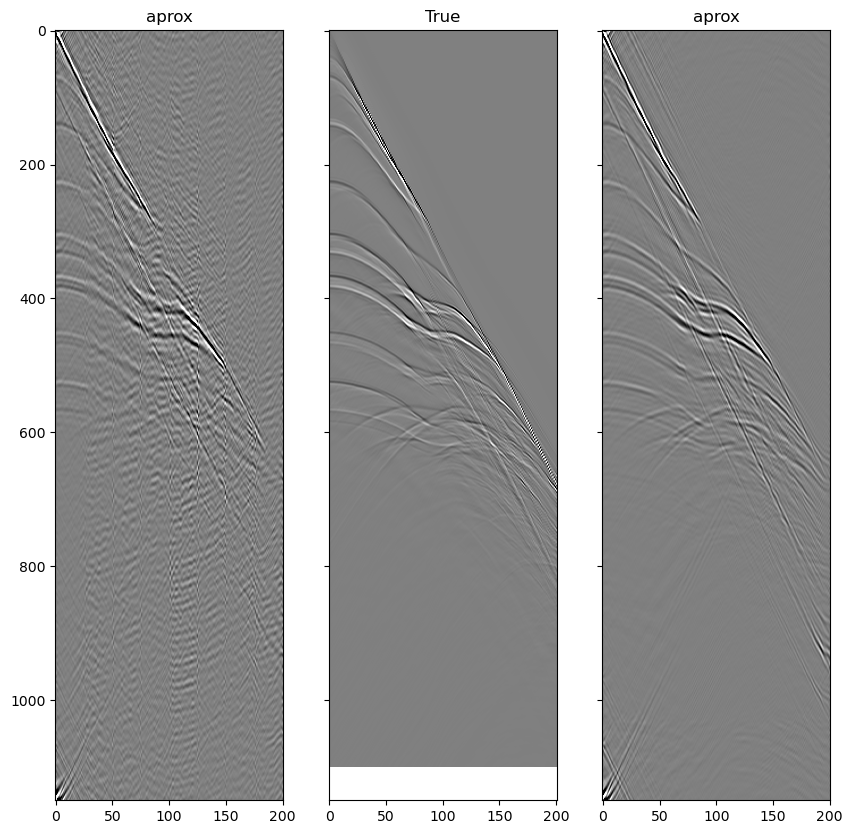


  virt = 100



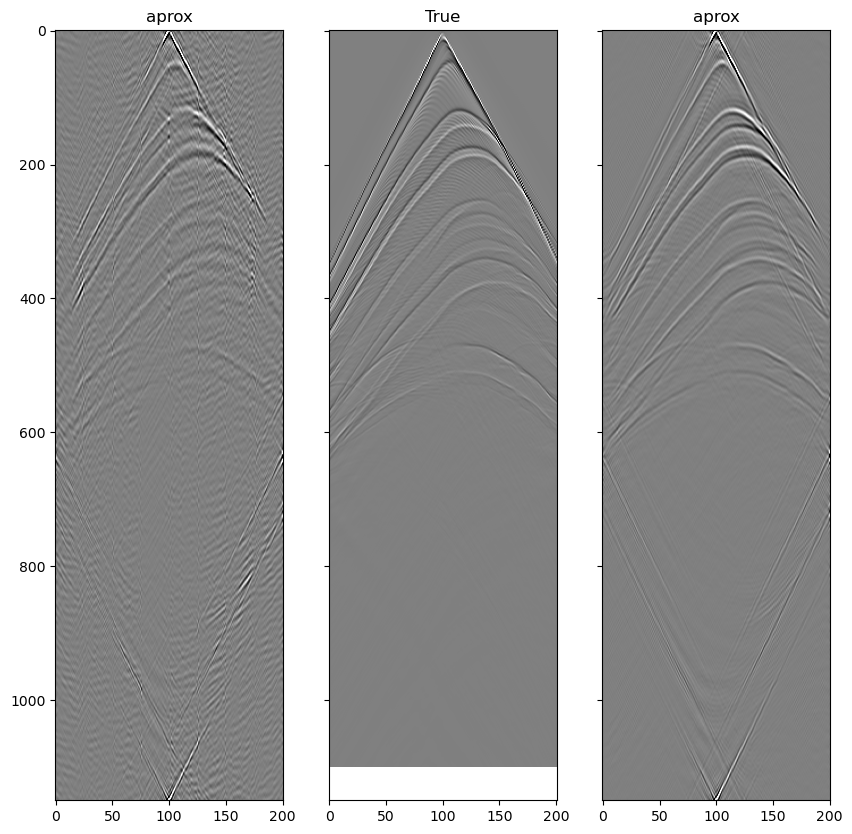


  virt = 200



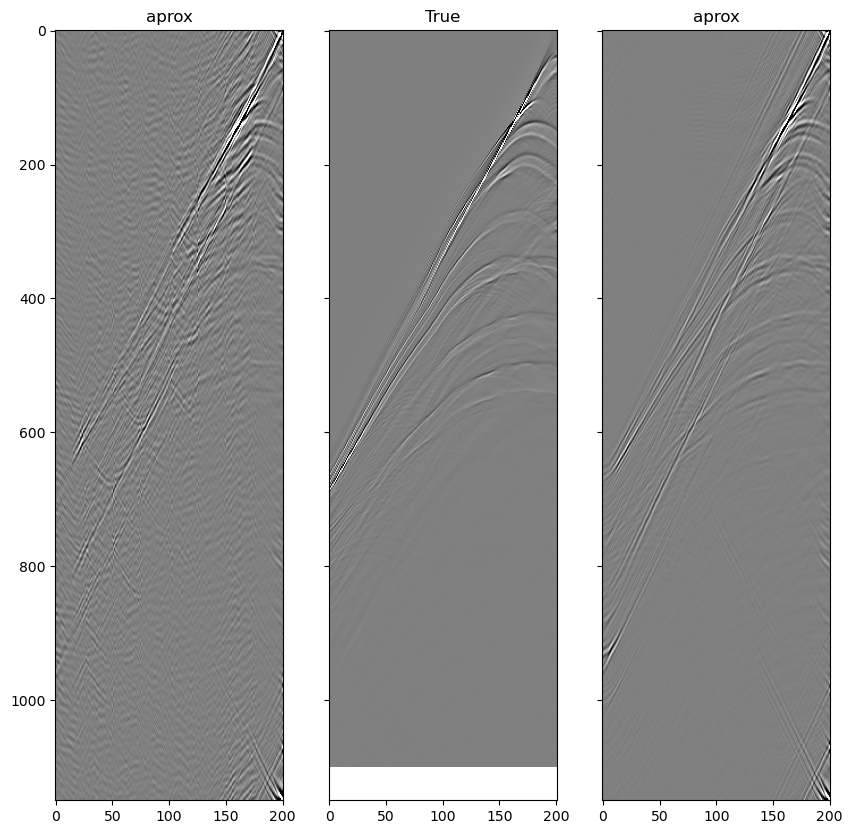

In [33]:
clip = 0.07
for iv in range(0, nr, 100):
    print(f'\n  virt = {iv}\n')
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
    
    axs[0].imshow(x_sc_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_sc_t).max(), vmax=clip*np.abs(x_sc_t).max())
    axs[0].set_title(f'aprox')
    axs[0].axis('tight')
    
    axs[1].imshow(x_true_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_true_t).max(), vmax=clip*np.abs(x_true_t).max())
    axs[1].set_title(f'True')
    axs[1].axis('tight')
    
    axs[2].imshow(x_full_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_sc_t).max(), vmax=clip*np.abs(x_sc_t).max())
    axs[2].set_title(f'aprox')
    axs[2].axis('tight')
    
    plt.show()

In [38]:
bs = sc_w.tree.index[9].shape[0]
((bs**2*3)*7*3)+(3*rank**2*(7**2-7*1))*nfmax*16

40359375

### symmetry

In [41]:
class Recop(object):
    def __init__(self, geom, rks_c, b_size, disp = 0):
        self.geom = geom
        self.r = rks_c
        self.b_size = b_size
        self.disp = disp
    def __call__(self,  vec):
        t0 = time()
        tmp = 0
        ans = np.array([])
        for i in range(nfmax):
            n = self.b_size[i]
            sc = vec_to_sc(self.geom, vec[tmp:tmp+n], self.r, self.r)
            ans = np.concatenate((ans, 0.5*(sc.to_vec + sc.T.to_vec)))
            tmp = tmp + n
        if self.disp:
            print(f"Matvec time:{time() - t0}, helm: {helm}")
        return ans

# Recop =  0.5 * (Identity(nfmax * nr * nr) + \
#                 Transpose((nfmax, nr, nr), (0, 2, 1)))

In [42]:
matvec  = Recop(geom, w_full[0].rks_c, b_size)
rmatvec = Recop(geom, w_full[0].rks_c, b_size)
rcp_lo  = LinearOperator((n_lo, n_lo), matvec=matvec, rmatvec=rmatvec)
lo_sym  = mm_lo * rcp_lo

In [44]:
### dot test (passed)
np.random.seed(0)
u_vec = np.random.rand(n_lo)
# print(np.linalg.norm(u_vec))
# np.random.seed(1)
v_vec = np.random.rand(n_lo)
# print(np.linalg.norm(v_vec))

test0 = v_vec.T.conj()@(rcp_lo.matvec(u_vec))
test1 = (rcp_lo.rmatvec(v_vec)).T.conj() @ u_vec

np.linalg.norm(test0 - test1)/ np.linalg.norm(test0)

4.3708854950601267e-16

In [45]:
### dot test (passed)
np.random.seed(0)
u_vec = np.random.rand(n_lo)
# print(np.linalg.norm(u_vec))
# np.random.seed(1)
v_vec = np.random.rand(n_lo)
# print(np.linalg.norm(v_vec))

test0 = v_vec.T.conj()@(lo_sym.matvec(u_vec))
test1 = (lo_sym.rmatvec(v_vec)).T.conj() @ u_vec

np.linalg.norm(test0 - test1)/ np.linalg.norm(test0)

2.4562622938263177e-14

In [47]:
t0 = time()
ans = lsqr(lo_sym, b_full, damp=1e-10, iter_lim=iter_lim, show=1)[0]
print(f"Time: {time()-t0} sec")

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 2130200 rows and 2130200 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   9.444e+01  9.444e+01    1.0e+00  2.0e+00


/Users/sushnid/miniconda3/envs/geo/lib/python3.9/site-packages/scipy/sparse/linalg/_isolve/lsqr.py:562: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


     1 -4.43311e-09   6.641e+01  6.641e+01    7.0e-01  5.9e-01   2.6e+02  1.0e+00
     2 -1.03746e-08   5.349e+01  5.349e+01    5.7e-01  3.1e-01   4.1e+02  2.3e+00
     3 -1.86906e-08   4.575e+01  4.575e+01    4.8e-01  2.0e-01   5.0e+02  3.9e+00
     4 -2.78172e-08   4.159e+01  4.159e+01    4.4e-01  1.5e-01   5.8e+02  5.5e+00
     5 -4.01211e-08   3.846e+01  3.846e+01    4.1e-01  1.0e-01   6.5e+02  7.4e+00
     6 -5.29742e-08   3.664e+01  3.664e+01    3.9e-01  8.4e-02   7.1e+02  9.3e+00
     7 -6.78746e-08   3.534e+01  3.534e+01    3.7e-01  6.5e-02   7.7e+02  1.1e+01
     8 -8.40399e-08   3.445e+01  3.445e+01    3.6e-01  5.2e-02   8.2e+02  1.3e+01
     9 -1.01013e-07   3.383e+01  3.383e+01    3.6e-01  4.4e-02   8.7e+02  1.6e+01
    10 -1.21884e-07   3.331e+01  3.331e+01    3.5e-01  3.5e-02   9.2e+02  1.8e+01
    11 -1.43578e-07   3.293e+01  3.293e+01    3.5e-01  3.1e-02   9.6e+02  2.1e+01
    12 -1.66951e-07   3.262e+01  3.262e+01    3.5e-01  2.7e-02   1.0e+03  2.3e+01
    13 -1.92514e

In [48]:
x_sc_s_fr = np.zeros((nfmax,nr,nr),dtype=complex)
tmp = 0
for i_fr in range(nfmax):
    print(i_fr)
    x_sc = vec_to_sc(geom, ans[tmp:tmp+b_size[i_fr]], w_full[i_fr].rks_r, w_full[i_fr].rks_r)
    tmp = tmp + b_size[i_fr]
    v = v_full[i_fr]
    x_sc_s_fr[i_fr, :, :] = suv_to_mat(x_sc, v.T.conj, v.conj)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [49]:
# x_full_t = ((Fopf.H @ (IopHf @ x_fr.ravel())).real).reshape(nt, nr, nr)
x_sc_s_t = ((Fopf.H @ (IopHf @ x_sc_s_fr.ravel())).real).reshape(nt, nr, nr)
# x_true_t = R1.transpose(1, 0, 2).copy()


  virt = 0



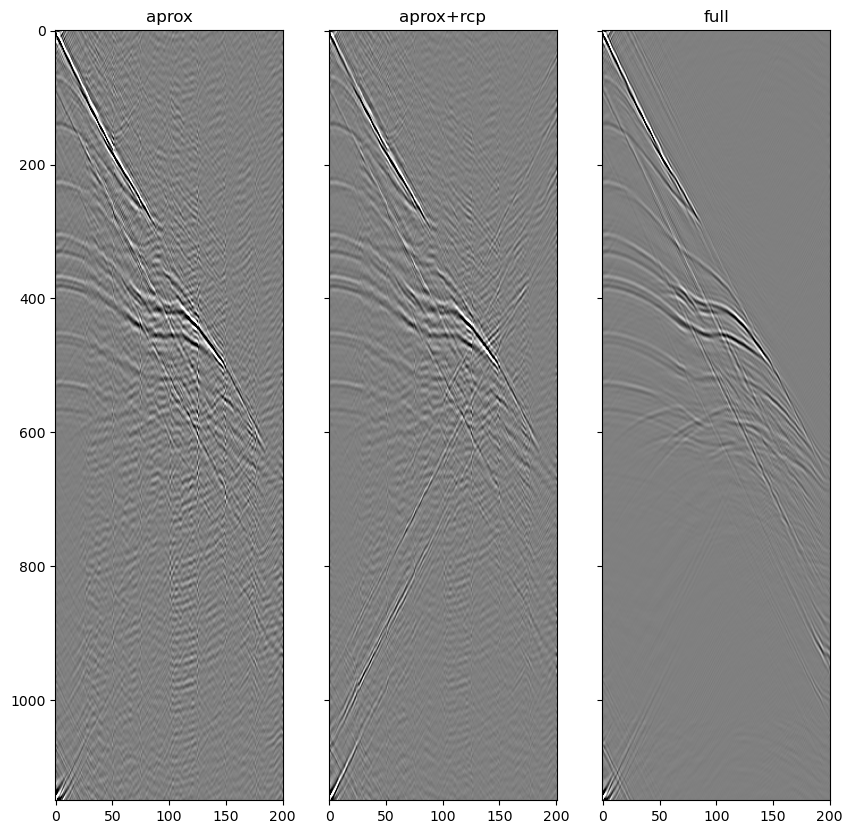


  virt = 100



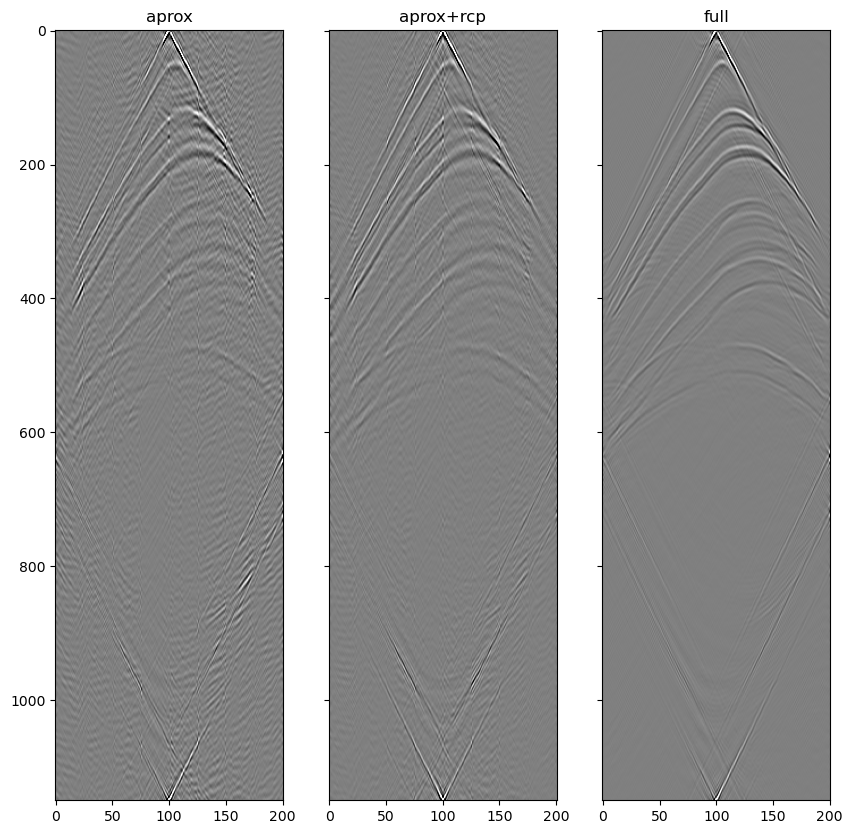


  virt = 200



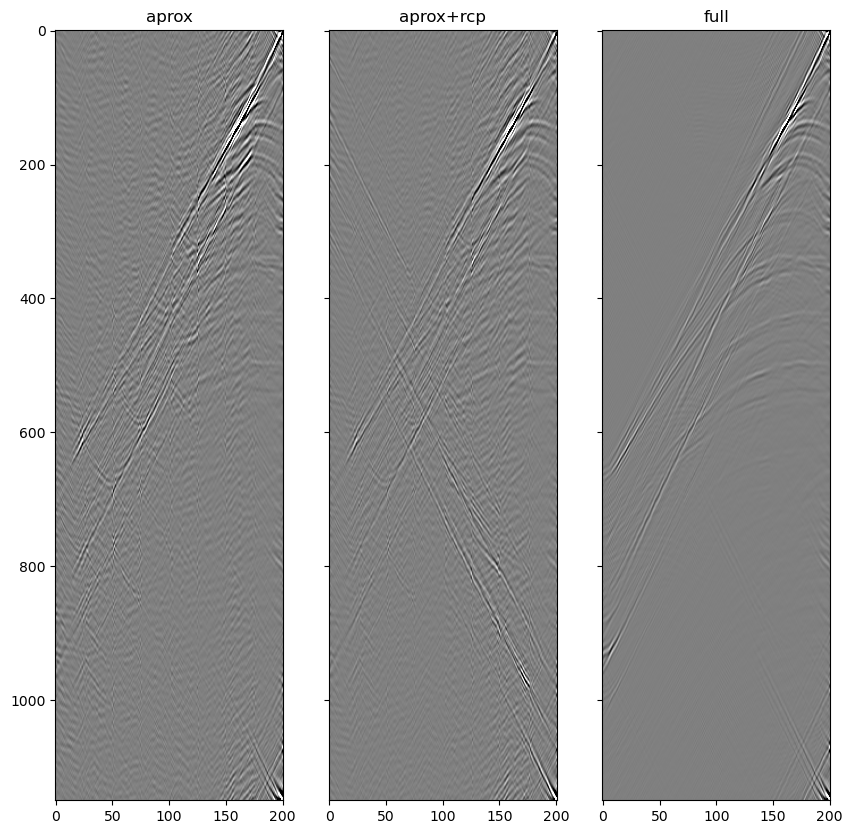

In [60]:
# plot
clip = 0.07
for iv in range(0, nr, 100):
    print(f'\n  virt = {iv}\n')
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
    
    axs[0].imshow(x_sc_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_sc_t).max(), vmax=clip*np.abs(x_sc_t).max())
    axs[0].set_title(f'aprox')
    axs[0].axis('tight')
    
    
    axs[1].imshow(x_sc_s_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_sc_t).max(), vmax=clip*np.abs(x_sc_t).max())
    axs[1].set_title(f'aprox+rcp')
    axs[1].axis('tight')
    
    axs[2].imshow(x_full_t[:,:,iv], cmap='gray', vmin=-clip*np.abs(x_full_t).max(), vmax=clip*np.abs(x_full_t).max())
    axs[2].set_title(f'full')
    axs[2].axis('tight')
    
    plt.show()

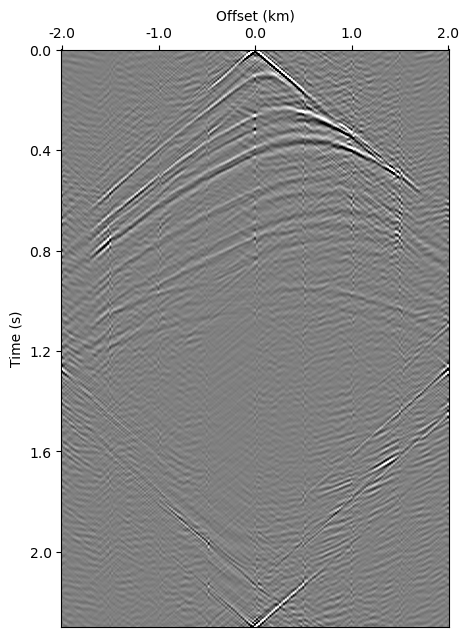

In [34]:
#h2
from matplotlib import ticker

clip = 0.05
iv = 100

x = x_sc_t
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 7.5))    
ax.imshow(x[:nt,:,iv], cmap='gray', vmin=-clip*np.abs(x).max(), vmax=clip*np.abs(x).max())
ax.set_ylabel('Time (s)')
ax.set_xlabel(f'Offset (km)')
ax.xaxis.set_label_position('top')

positions = np.arange(0,201,50)
labels = np.arange(-2.0,3)
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))

positions = np.arange(0,1500,200)
labels = np.arange(0, 3, 0.4)
labels = [round(x,1) for x in labels]
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.axis('tight')

fig.savefig('../figs/paper/h2.png')

# playground

In [9]:
nt


1150

In [10]:
ns

201

In [11]:
Gfft.shape

(200, 201, 201)

In [12]:
d.shape

(1150, 201, 201)

In [15]:
pdown.shape

(201, 1150, 201)

In [17]:
pdown.dtype

dtype('float32')

In [16]:
pup.shape

(201, 1150, 201)

In [ ]:
ns *  nv * nt * 4 * 1e-6

ns *  nv * nfmax * 8 * 1e-6

ns *  50 * nfmax * 8 * 1e-6

50 *  50 * nfmax * 8 * 1e-6

ns * nv * nt * 4 * 1e-6 * 2 + ns *  nv * nfmax * 8 * 1e-6

ns *  nv * nfmax * 8 * 1e-6 *3

50 *  50 * nfmax * 8 * 1e-6 *3

In [39]:
40.4/3


13.466666666666667